In [75]:
#importing Libraries 
import pandas as pd 
import numpy as np 
import re #regular expression 
import nltk as nlp 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
#Read data from CSV file
df = pd.read_csv(r"C:\Gender_classifier_project\gender-classifier.csv")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,���It felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

In [35]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [36]:
#drop columns
df.drop(['_unit_id', '_golden','_unit_state','_trusted_judgments','_last_judgment_at','profile_yn','profile_yn:confidence',
         'user_timezone','created','fav_number', 'link_color', 'name',
         'gender_gold','profile_yn_gold','profileimage',
          'retweet_count', 'sidebar_color','tweet_coord',
         'tweet_created','tweet_count','tweet_created', 'tweet_id', 
         'tweet_location', 'user_timezone'],
        axis='columns', inplace=True)

In [37]:
df.columns

Index(['gender', 'gender:confidence', 'description', 'text'], dtype='object')

In [38]:
df.shape

(20050, 4)

In [39]:
#Dropping Null values 
df.dropna(how='any',axis=0, inplace=True)

In [40]:
df.shape 

(16224, 4)

In [41]:
#Merge description and text on one column 
df["tweet"] = df.description + df.text
df["gender"] = df.gender

In [42]:
df.head(3)

,gender,gender:confidence,description,text,tweet
0,male,1.0000,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.Robbie E Responds To Crit...
1,male,1.0000,I'm the author of novels filled with family dr...,���It felt like they were my friends and I was...,I'm the author of novels filled with family dr...
2,male,0.6625,louis whining and squealing and all,i absolutely adore when louis starts the songs...,louis whining and squealing and alli absolutel...


In [43]:
# To count the words 
get_female = df["gender"] == "female"
get_male = df["gender"] == "male"
get_brand = df["gender"] == "brand"

In [44]:
female_rows = df[get_female]
male_rows = df[get_male]
brand_rows = df[get_brand]

In [45]:
print("total female tweets: ",female_rows.tweet.count())
print("total male tweets:   ",male_rows.tweet.count())
print("total brand tweets:  ",brand_rows.tweet.count())

total female tweets:  5725
total male tweets:    5469
total brand tweets:   4328


In [46]:
#labelling 
female_rows.gender = 0    
male_rows.gender = 1     
brand_rows.gender = 2    

C:\Users\Aryaf\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [47]:
#Word Normalization
#Lemmatization is an organized and step-by-step process 
#of obtaining the root form of the word.
lemma = nlp.WordNetLemmatizer()  

In [48]:
#create empty list , convert string into list by using for loop 
tweets_list = []          
for each in df.tweet:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        # clean unnecesarry chars
    each = each.lower()                                                              # lowercase all
    each = nlp.word_tokenize(each)                                                   # split all by tokenizing
    each = [word for word in each if not word in set(stopwords.words("english"))]    # delete stop words from array
    each = [lemma.lemmatize(word) for word in each]                                  # lemmatize "memories" -> "memory"
    each = " ".join(each)                                                            # make them one string again
    tweets_list.append(each)    

In [49]:
tweets_list[:5]

['sing rhythm robbie e responds critic win eddie edward worldtitleseries http co nsybbmvjkz',
 'author novel filled family drama romance felt like friend living story http co arnge yhno retired ian http co cizcanpqfz',
 'louis whining squealing alli absolutely adore louis start song hit hard feel good',
 'mobile guy er shazam google kleiner perkins yahoo sprint pc airtouch air force stanford gsb uva dad husband brother golfer hi jordanspieth looking url use ifttt typically see advanced user pgatour http co h ou pe l',
 'ricky wilson best frontman kaiser chief best band xxxx thank kaiser chief incredible year gig memory cherish always xxxxxxxwatching neighbour sky catching neighbs xxx xxx']

In [50]:
#create bag of words
max_features = 600
count_vectorizer = CountVectorizer(max_features=max_features,stop_words = "english")
sparce_matrix = count_vectorizer.fit_transform(tweets_list).toarray()
words = count_vectorizer.get_feature_names()

In [87]:
sparce_matrix = count_vectorizer.fit_transform(tweets_list).toarray()
sparce_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [89]:
print("Most used 600 words on all tweets:",words[:600])

Most used 600 words on all tweets: ['account', 'actually', 'age', 'air', 'album', 'amas', 'amazing', 'america', 'american', 'amp', 'animal', 'answer', 'app', 'apple', 'area', 'art', 'artist', 'ask', 'author', 'available', 'award', 'away', 'awesome', 'baby', 'bad', 'band', 'based', 'bc', 'beat', 'beautiful', 'beauty', 'bed', 'beer', 'believe', 'best', 'better', 'big', 'birthday', 'bit', 'bitch', 'black', 'blog', 'blogger', 'blue', 'body', 'book', 'booking', 'born', 'boy', 'brand', 'break', 'breaking', 'bring', 'brother', 'build', 'building', 'business', 'buy', 'called', 'came', 'cancer', 'car', 'card', 'care', 'cat', 'cause', 'ceo', 'chance', 'change', 'channel', 'character', 'check', 'chief', 'child', 'chill', 'christ', 'christian', 'city', 'class', 'click', 'club', 'coach', 'coffee', 'college', 'com', 'come', 'comic', 'coming', 'community', 'company', 'conservative', 'consultant', 'contact', 'content', 'continuous', 'cool', 'country', 'course', 'cover', 'crazy', 'creative', 'credit', 

In [53]:
#Train and test split 
y = df.gender.values
x = sparce_matrix

In [54]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2)  #80% , 20%

#I am going to train some different classification algorithms
#and at the end of this section I am going to determine
#best classification algorithm for this dataset.

In [55]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(train_x,train_y)
print(NBC.score(test_x,test_y))

0.22496147919876733


In [81]:
confusion_matrix(test_y, y_pred)

array([[558, 154, 129,   5],
       [123, 765, 247,   5],
       [179, 416, 501,   7],
       [ 30,  81,  45,   0]], dtype=int64)

In [56]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(train_x,train_y)
print(LR.score(test_x,test_y))

0.5543913713405239


C:\Users\Aryaf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
#Random Forest Classification
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(train_x,train_y)
print (rfc.score(test_x,test_y))

0.5463790446841295


In [58]:
#MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nb = MultinomialNB()
nb.fit(train_x,train_y)
y_pred = nb.predict(test_x)
accuracy = 100.0 * accuracy_score(test_y, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  56.2095531587057


In [ ]:
#MultinomialNB is the best!! 

In [73]:
cm = confusion_matrix(test_y,y_pred)

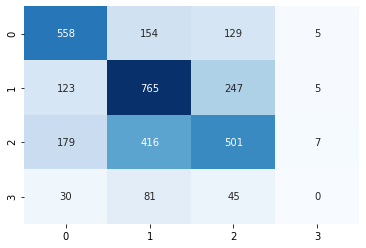

In [74]:
sns.heatmap(cm,cbar=False,annot=True,cmap="Blues",fmt="d")
plt.show()

#Brand is easy to seperate but genders are relatively more complex 

In [61]:
#analysis
df.gender.value_counts()

female     5725
male       5469
brand      4328
unknown     702
Name: gender, dtype: int64

In [62]:
#drop unknown 
df.drop(index=df[df['gender'] == 'unknown'].index, inplace=True)

In [63]:
df.gender.value_counts()

female    5725
male      5469
brand     4328
Name: gender, dtype: int64

In [93]:
##clean text 
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

df['Cleaning_text'] = [cleaning(s) for s in df['text']]
df['Cleaning_description'] = [cleaning(s) for s in df['description']]

stop = set(stopwords.words('english'))
df['Cleaning_text'] = df['Cleaning_text'].str.lower().str.split()
df['Cleaning_text'] = df['Cleaning_text'].apply(lambda x : [item for item in x if item not in stop])
df['Cleaning_description'] = df['Cleaning_description'].str.lower().str.split()
df['Cleaning_description'] = df['Cleaning_description'].apply(lambda x : [item for item in x if item not in stop])

In [94]:
#Word Frequency Count Based On Gender
Male = df[df['gender'] == 'male']
Female = df[df['gender'] == 'female']
Brand = df[df['gender'] == 'brand']
Male_Words = pd.Series(' '.join(Male['Cleaning_text'].astype(str)).lower().split(" ")).value_counts()[:20]
Female_Words = pd.Series(' '.join(Female['Cleaning_text'].astype(str)).lower().split(" ")).value_counts()[:20]
Brand_words = pd.Series(' '.join(Brand['Cleaning_text'].astype(str)).lower().split(" ")).value_counts()[:10]


print('famele words',str(Female_Words), sep='\n\n')
print("")
print('male words',str(Male_Words), sep='\n\n')
print("")
print('Brand words',str(Brand_words), sep='\n\n')

famele words

'like',      396
'get',       309
'one',       267
'day',       243
'go',        235
'love',      231
'amp',       195
'people',    192
'time',      190
'last',      171
'know',      170
'new',       169
'got',       155
'make',      154
'back',      152
'best',      145
'still',     141
'want',      137
'see',       136
'u',         133
dtype: int64

male words

'like',      320
'get',       307
'one',       209
'new',       192
'time',      187
'go',        185
'love',      171
'people',    154
'day',       152
'see',       151
'good',      150
'amp',       148
'know',      143
'back',      139
'would',     138
'think',     133
'make',      132
'got',       130
'last',      129
'best',      126
dtype: int64

Brand words

'weather',    2278
['get',       1160
'updates',    1145
'channel']    1137
'new',         193
'amp',         189
'us',          164
'get',         162
'like',        140
'one',         126
dtype: int64


<AxesSubplot:>

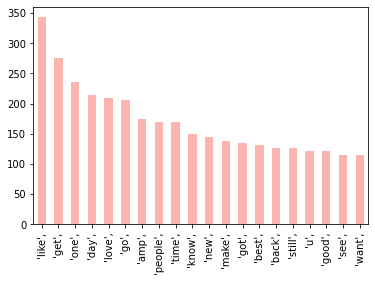

In [66]:
Female_Words.plot(kind='bar',stacked=True, colormap='Pastel1')

<AxesSubplot:>

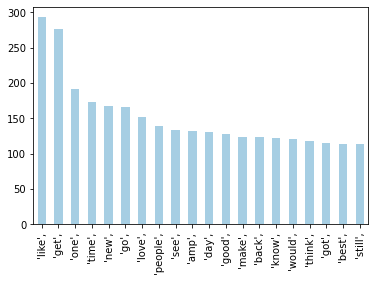

In [67]:
Male_Words.plot(kind='bar',stacked=True, colormap='Paired')

<AxesSubplot:>

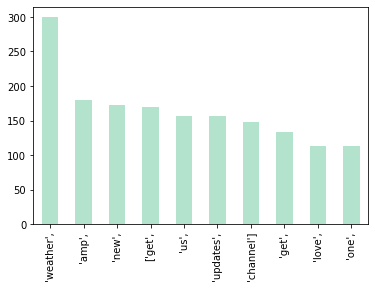

In [68]:
Brand_words.plot(kind='bar',stacked=True, colormap='Pastel2')

<AxesSubplot:>

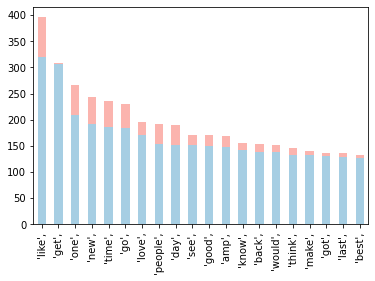

In [95]:
#A common word between female , male
Female_Words.plot(kind='bar',stacked=True, colormap='Pastel1')
Male_Words.plot(kind='bar',stacked=True, colormap='Paired')

In [86]:
from sklearn import metrics
print(metrics.classification_report(test_y, y_pred))

              precision    recall  f1-score   support

       brand       0.63      0.66      0.64       846
      female       0.54      0.67      0.60      1140
        male       0.54      0.45      0.49      1103
     unknown       0.00      0.00      0.00       156

    accuracy                           0.56      3245
   macro avg       0.43      0.45      0.43      3245
weighted avg       0.54      0.56      0.55      3245

